In [1]:
import os
import argparse
import time
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [20]:
class Args:
    method = 'dopri5' # choices=['dopri5', 'adams']
    data_size = 1000
    batch_time = 10
    batch_size = 20
    niters = 2000
    test_freq = 20
    viz = True
    gpu = True
    adjoint = False

args=Args()

In [21]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [22]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [23]:
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., args.data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])

In [24]:
class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y**3, true_A)

In [25]:
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [26]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:args.batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [27]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

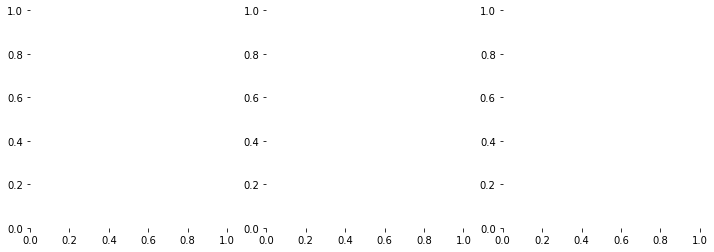

In [56]:
def visualize(true_y, pred_y, odefunc, itr):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)
    makedirs('png')

    if args.viz:
        


        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)

        fig.tight_layout()
        plt.savefig('png/{:03d}'.format(itr))
        plt.draw()
        plt.pause(0.001);
        

In [57]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)

In [58]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

No handles with labels found to put in legend.


Iter 0020 | Total Loss 0.612806


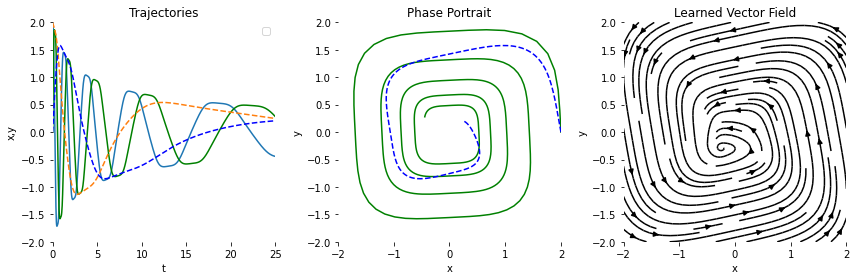

No handles with labels found to put in legend.


Iter 0040 | Total Loss 0.596309


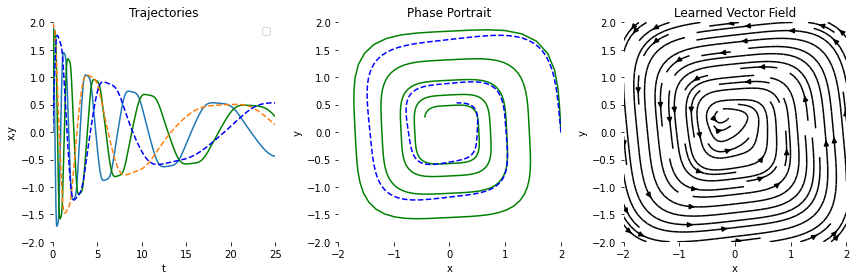

Iter 0060 | Total Loss 0.638612


No handles with labels found to put in legend.


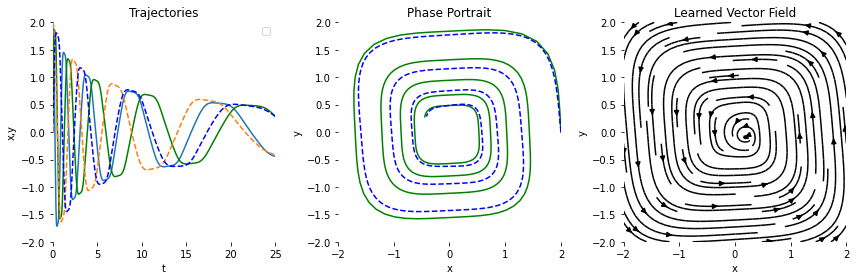

No handles with labels found to put in legend.


Iter 0080 | Total Loss 0.440109


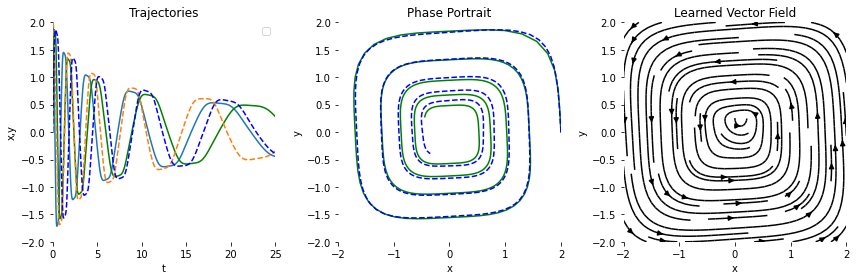

No handles with labels found to put in legend.


Iter 0100 | Total Loss 0.598009


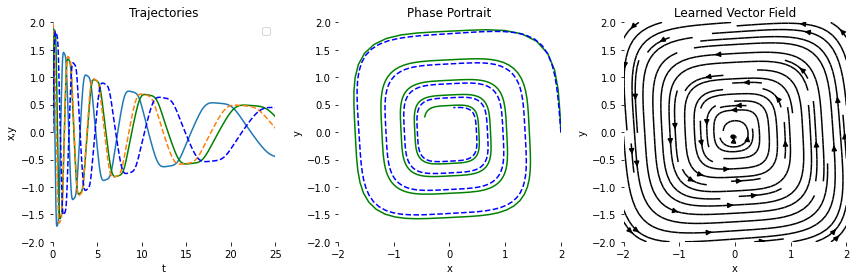

RuntimeError: python_error

In [59]:
%matplotlib inline
ii = 0

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, args.niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % args.test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()